<a href="https://colab.research.google.com/github/jecampagne/JaxTutos/blob/main/JAX_exo_sum_image_patches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objectives:
The goal is to sum patches of identical size cut in a 2D image, and to see what is the trends on compilation/execution on CPU & GPU. We propose different methods, and it is up to you to propose your own.

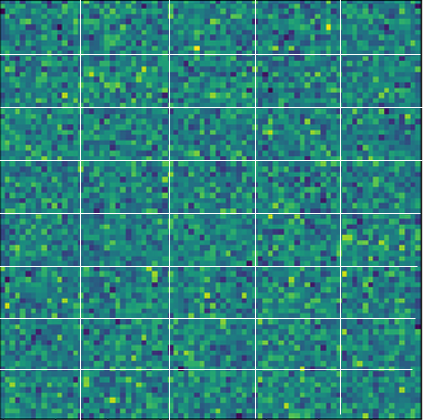

In [2]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import numpy as np
from functools import partial

In [3]:
jax.__version__

'0.4.26'

In [4]:
jax.devices()

[CpuDevice(id=0)]

# Compilation/Execution time on CPU & GPU devices

In [64]:
#clear JIT to be sure to start with fresh codes
jax.clear_caches()

expend_factor = 5  # [up-to 10 on Colab CPU]
nxwrap,nywrap = 16, 10
Nx,Ny = nxwrap*5*expend_factor,nywrap*8*expend_factor
im = jax.random.normal(jax.random.PRNGKey(10),(Nx,Ny))


## 2 nested explicit simple for loops

In [65]:
@partial(jax.jit, static_argnames=("nxwrap","nywrap"))
def make_fim_nested_for_loop(im,nxwrap,nywrap):

  fim = jnp.zeros((nywrap, nxwrap), dtype=im.dtype)

  nx = im.shape[1] // nxwrap
  ny = im.shape[0] // nywrap

  yl = 0
  for _ in range(ny):
      yh = yl + nywrap

      xl = 0
      for _ in range(nx):
          xh = xl + nxwrap
          fim = fim + im[yl:yh, xl:xh]
          xl = xh

      yl = yh

  return fim

In [66]:
%time fim_nested_for_loop = make_fim_nested_for_loop(im,nxwrap,nywrap)

CPU times: user 1.83 s, sys: 16.5 ms, total: 1.84 s
Wall time: 1.97 s


In [67]:
%timeit _= make_fim_nested_for_loop(im,nxwrap,nywrap).block_until_ready()

271 µs ± 7.04 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## nested 2-lax_fori_loop

In [68]:
@partial(jax.jit, static_argnames=("nxwrap","nywrap"))
def make_fim_nested_fori_loop(im,nxwrap,nywrap):
  def _body_j(j, vals):
        i, im, fim = vals

        ii = i% nywrap
        jj = j% nxwrap

        fim = fim.at[ii, jj].add(im[i, j])

        return i, im, fim

  def _body_i(i, vals):
        im,fim = vals
        _,_, fim = jax.lax.fori_loop(0, im.shape[1], _body_j, (i, im, fim))
        return im,fim

  fim = jnp.zeros((nywrap, nxwrap), dtype=im.dtype)
  _,fim = jax.lax.fori_loop(0, im.shape[0], _body_i, (im,fim))
  return fim

In [69]:
%time fim_nested_fori_loop = make_fim_nested_fori_loop(im,nxwrap,nywrap)

CPU times: user 142 ms, sys: 975 µs, total: 143 ms
Wall time: 141 ms


In [70]:
%timeit _= make_fim_nested_fori_loop(im,nxwrap,nywrap).block_until_ready()

1.36 ms ± 373 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## 1-lax_fori_loop-unrolled

In [71]:
@partial(jax.jit, static_argnames=("nxwrap","nywrap"))
def make_fim_nested_for_loop_unroll(im, nxwrap, nywrap):

    nx = im.shape[1] // nxwrap
    ny = im.shape[0] // nywrap

    def _body_ij(ij, vals):
        i, j = jnp.unravel_index(ij, (ny, nx))
        im, fim = vals
        xl = j * nxwrap
        yl = i * nywrap
        fim = fim + jax.lax.dynamic_slice(im, (yl, xl), (nywrap, nxwrap))   #<-----------
        return im, fim


    fim = jnp.zeros((nywrap, nxwrap), dtype=im.dtype)

    _, fim = jax.lax.fori_loop(0, ny * nx, _body_ij, (im, fim), unroll=10)

    return fim

In [72]:
%time fim_nested_for_loop_unroll = make_fim_nested_for_loop_unroll(im,nxwrap,nywrap)

CPU times: user 352 ms, sys: 1.99 ms, total: 354 ms
Wall time: 353 ms


In [73]:
%timeit _ =  make_fim_nested_for_loop_unroll(im,nxwrap,nywrap).block_until_ready()

64.7 µs ± 3.83 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## Index brodcasting & vmapping

In [74]:
@partial(jax.jit, static_argnames=("nxwrap", "nywrap"))
def make_fim_broadcast(sim, nxwrap, nywrap):
    def rolling_window_i(arr, wind):
        idx = (
            jnp.arange(arr.shape[0] - wind + 1)[::wind, None]
            + jnp.arange(wind)[None, :]
        )
        return arr[idx]

    # the starting array shape is (Ny, Nx) with Nx = sim.shape[1] and Ny = sim.shape[0]
    # and below nx = Nx // nxwrap and ny = Ny // nywrap
    y = rolling_window_i(sim, nywrap)
    # now the array shape is (ny, nywrap, Nx)
    y = jnp.moveaxis(y, -1, -2)
    # now the array shape is (ny, Nx, nywrap)
    # this vampped function acts on the second to first axis since
    # the original function acts on the first axis and vmap adds an axis at the end
    y = jax.vmap(partial(rolling_window_i, wind=nxwrap))(y)
    # now the array shape is (ny, nx, nxwrap, nywrap)
    y = y.reshape(-1, nxwrap, nywrap)
    # now the array shape is (ny * nx, nxwrap, nywrap)
    y = jnp.moveaxis(y, -1, -2)
    # now the array shape is (ny * nx, nywrap, nxwrap)
    # then we sum on axis 0 to get the final shape (nywrap, nxwrap)
    return y.sum(axis=0)


In [75]:
%time fim_broadcast= make_fim_broadcast(im,nxwrap,nywrap)

CPU times: user 83.2 ms, sys: 0 ns, total: 83.2 ms
Wall time: 85.4 ms


In [76]:
%timeit _ =  make_fim_broadcast(im,nxwrap,nywrap).block_until_ready()

864 µs ± 236 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [77]:
def max_diff(x,x_ref):
  return np.max(np.abs(x-x_ref))

In [78]:
max_diff(fim_nested_fori_loop,fim_nested_for_loop), max_diff(fim_nested_for_loop_unroll,fim_nested_for_loop), max_diff(fim_broadcast,fim_nested_for_loop)

(0.0, 0.0, 8.526512829121202e-14)